In [1]:
import numpy as np
import pandas as pd
from scipy.linalg import eigh, expm, ishermitian

import seaborn as sns
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, QuantumRegister, transpile
from qiskit.circuit.library import UnitaryGate
from qiskit_aer import Aer

np.random.seed(9112001)

In [2]:
def get_itimevol_circuit(N, M, H, t, psi_0):
    n_anc = 2 * M
    
    anc_idxs = list(range(n_anc))
    sys_idxs = list(range(n_anc, n_anc + N))
    alpha    = 2 * np.arctan(np.sqrt(0.5))
    beta     = 0.5 * np.pi
    gamma    = -1.5 * np.pi
    anc      = QuantumRegister(n_anc, name="a")
    syst     = QuantumRegister(N, name="q")
    qc       = QuantumCircuit(anc, syst)

    qc.initialize(psi_0, sys_idxs)

    for i in range(2 * M - 1, 0, -2): 
        # setup gates for ancillary qubits
        qc.ry(alpha, i - 1)
        qc.ry(beta, i)
        qc.cx(i - 1, i, ctrl_state = 0)
        qc.crz(gamma, control_qubit = i - 1, target_qubit = i)

        U_1    = expm(1j * H * t / M)
        U_1_op = UnitaryGate(U_1, label="U(-t/M)").control(1)
        qc.append(U_1_op, [i - 1] + sys_idxs) # control on qubit i - 1 and act on the system qubits

        U_2    = expm(-2j * H * t / M)
        U_2_op = UnitaryGate(U_2, label="U(2t/M)").control(2)
        qc.append(U_2_op, [i - 1, i] + sys_idxs) # control on qubits i - 1 and i and act on the system qubits

    # setup measurement qubits
    qc.h(anc_idxs)

    return qc

In [7]:
# consider 3 qubits
N   = 2
N_q = 2 ** N
t   = 2

""" Build A matrix such that the Hamiltoninan has
    entries with both real and imaginary part 
    inside (-bound, bound)
"""
bound = 1
A = 0.5 * (2 * bound * np.random.rand(N_q, N_q) + 2 * bound * 1j * np.random.rand(N_q, N_q) - bound) 
H = A + A.conj().T
print("Hermeticity check: ", ishermitian(H))

psi_0 = np.ones(N_q)
psi_0 /= np.linalg.norm(psi_0)
print(psi_0)

Hermeticity check:  True
[0.5 0.5 0.5 0.5]


In [18]:
M_max    = 10
M_values = np.arange(1, M_max + 1)

data = []

for M in M_values:
    qc = get_itimevol_circuit(N, M, H, t, psi_0)

    aer_sim = Aer.get_backend("aer_simulator_statevector_gpu")
    qc_tp   = transpile(qc, backend=aer_sim, optimization_level=1)

    num_nl = qc_tp.num_nonlocal_gates()
    depth = qc_tp.depth()
    data.append((M, num_nl, depth))


/tmp/ipykernel_52285/3895435758.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(df, x = "M", y = "depth", markers=True, palette="tab10")


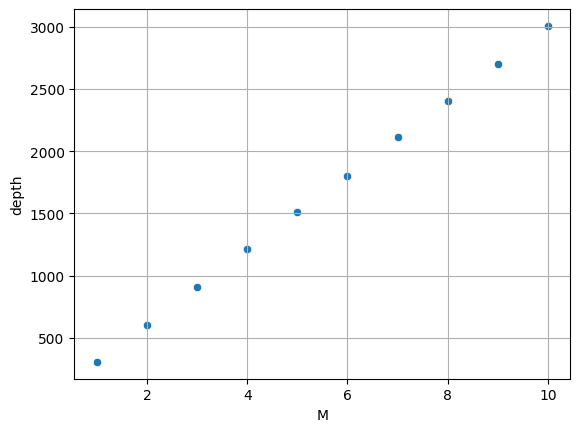

In [25]:
df = pd.DataFrame(data, columns=["M", "num_nl", "depth"])
sns.scatterplot(df, x = "M", y = "depth", markers=True, palette="tab10")
plt.grid()